<a href="https://colab.research.google.com/github/phamminh1998/GBM_Frontier_Market/blob/main/thesis_simulation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import importlib.util
import subprocess
import sys

def install_and_import(module_name):
    if importlib.util.find_spec(module_name) is None:
        print(f"{module_name} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", module_name])
    else:
        print(f"{module_name} is already installed.")

# Use the function for the libraries
install_and_import('pandas')
install_and_import('numpy')
install_and_import('matplotlib')

pandas is already installed.
numpy is already installed.
matplotlib is already installed.


# 1. Estimate parameters for Hochiminh Stocks

In [6]:
import numpy as np
import pandas as pd

# Assuming hose_df_2022 is already loaded as a pandas DataFrame
# Ensure the data is sorted by ticker and date
hose_df_2022 = hose_df_2022.sort_values(by=['ticker', 'date'])

# Initialize an empty list to store results
parameters = []

# Group by ticker and iterate over each group
for ticker, group in hose_df_2022.groupby('ticker'):
    # Calculate log returns
    log_returns = []
    
    for i in range(len(group)):
        if i == 0:
            # First day: compare 'close' with 'open'
            log_return = np.log(group.iloc[i]['close'] / group.iloc[i]['open'])
        else:
            # Rest of the days: compare 'close' with previous day's 'close'
            log_return = np.log(group.iloc[i]['close'] / group.iloc[i - 1]['close'])
        log_returns.append(log_return)
    
    # Convert log returns to a numpy array
    log_returns = np.array(log_returns)
    
    # Calculate mean (drift) and standard deviation (volatility) of log returns
    mu = log_returns.mean()
    sigma = log_returns.std()
    
    # Annualize the parameters
    trading_days = 249
    mu_annualized = mu * trading_days
    sigma_annualized = sigma * np.sqrt(trading_days)
    
    # Append the results for the current ticker
    parameters.append({
        'ticker': ticker,
        'mu': mu,
        'sigma': sigma,
        'mu_annualized': mu_annualized,
        'sigma_annualized': sigma_annualized
    })

# Convert the results to a DataFrame for easier viewing
parameters = pd.DataFrame(parameters)

print(parameters)
# Get concise summary information
print("\nInfo:")
parameters.info()

# Get summary statistics
print("\nSummary Statistics:")
print(parameters.describe())

# Save the parameters DataFrame to a CSV file in the root directory
parameters.to_csv('log_parameters.csv', index=False)
print("Parameters have been saved to 'log_parameters.csv'")

       ticker        mu     sigma  mu_annualized  sigma_annualized
0         ACB -0.001860  0.025599      -0.463131          0.403943
1         BCM  0.000907  0.028497       0.225939          0.449675
2         BID  0.000105  0.027770       0.026248          0.438196
3         BVH -0.000738  0.025849      -0.183751          0.407890
4         CTG -0.000942  0.027318      -0.234455          0.431073
5         FPT -0.000781  0.025997      -0.194385          0.410222
6         GAS  0.000186  0.026841       0.046379          0.423551
7         GVR -0.003982  0.033831      -0.991640          0.533846
8         HDB -0.002688  0.024972      -0.669355          0.394054
9         HPG -0.003837  0.034743      -0.955511          0.548243
10        MBB -0.002149  0.028694      -0.535090          0.452791
11        MSN -0.002446  0.030338      -0.609064          0.478723
12        MWG -0.004631  0.048278      -1.153047          0.761814
13        NVL -0.007495  0.027015      -1.866293          0.42

# 2. GBM simulation run on VN stocks

In [5]:
import pandas as pd

# Load the data
data_path = './data/hose_df_2023.csv'
hose_df_2023 = pd.read_csv(data_path)

# Convert 'date' column to datetime format
hose_df_2023['date'] = pd.to_datetime(hose_df_2023['date'])

# Sort the dataframe by ticker and date
hose_df_2023.sort_values(['ticker', 'date'], inplace=True)

#inspect dataframe
print(hose_df_2023)
print(hose_df_2023.info())

           date ticker   open   high    low  close   volume
248  2023-01-03    ACB  22.00  22.70  21.95  22.70  1547700
247  2023-01-04    ACB  22.85  22.85  22.55  22.65  7244400
246  2023-01-05    ACB  22.75  23.00  22.65  22.85  2104500
245  2023-01-06    ACB  22.80  23.35  22.60  23.15  8403100
244  2023-01-09    ACB  23.35  23.35  22.95  23.10  2491075
...         ...    ...    ...    ...    ...    ...      ...
7225 2023-12-25    VRE  22.85  23.40  22.85  23.40  3490400
7224 2023-12-26    VRE  23.35  23.50  23.15  23.30  2651000
7223 2023-12-27    VRE  23.30  23.45  23.20  23.25  3220300
7222 2023-12-28    VRE  23.25  23.70  23.25  23.50  6285000
7221 2023-12-29    VRE  23.65  23.65  23.30  23.30  4609200

[7968 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 7968 entries, 248 to 7221
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    7968 non-null   datetime64[ns]
 1   ticker  7968 no

In [6]:
import pandas as pd
from gbm import GBM_Simulator
import warnings
import random

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# Set the seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# Load the parameters DataFrame
parameters = pd.read_csv('log_parameters.csv')

# Directory to save the GBM simulation outputs
output_dir = 'gbm_price'

# Iterate over each ticker in the 2023 data
for ticker in hose_df_2023['ticker'].unique():
    # Get the data for the current ticker
    ticker_data = hose_df_2023[hose_df_2023['ticker'] == ticker]

    # Get the start and end dates
    start_date = ticker_data['date'].min().strftime('%Y-%m-%d')
    end_date = ticker_data['date'].max().strftime('%Y-%m-%d')

    # Get the initial price (open price of the first day)
    init_price = ticker_data.iloc[0]['open']

    # Get the annualized parameters for the current ticker
    ticker_params = parameters[parameters['ticker'] == ticker]
    if ticker_params.empty:
        continue  # Skip if no parameters found for the ticker
    mu_annualized = ticker_params['mu_annualized'].values[0]
    sigma_annualized = ticker_params['sigma_annualized'].values[0]

    # Number of business days between start_date and end_date
    n = len(pd.date_range(start_date, end_date, freq='B'))

    # Run the GBM simulation
    simulator = GBM_Simulator(
        start_date=start_date,
        end_date=end_date,
        output_dir=output_dir,
        T=1,  # Time in years
        n=n,
        symbol=ticker,
        init_price=init_price,
        mu=mu_annualized,
        sigma=sigma_annualized,
        num_sims=5000
    )
    simulator()

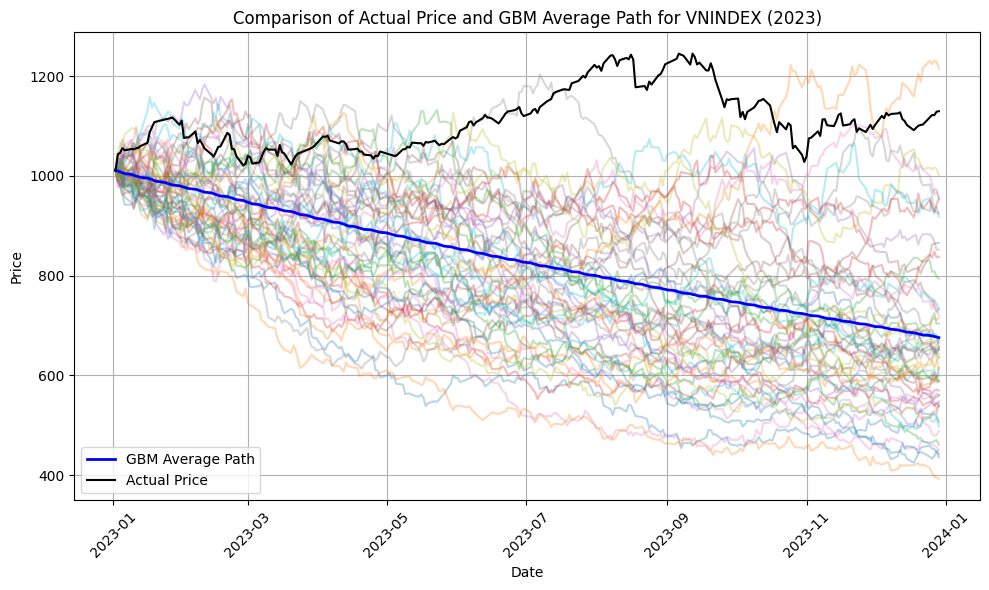

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Read the average path data
average_path_data = pd.read_csv('./gbm_price/VNINDEX.csv')

# Convert 'date' column to datetime format
average_path_data['date'] = pd.to_datetime(average_path_data['date'])

# Filter actual price data for ACB from hose_df_2023
actual_price_data = hose_df_2023[hose_df_2023['ticker'] == 'VNINDEX'][['date', 'open', 'close']]

# Get the minimum date and the corresponding open price
min_date = actual_price_data['date'].min()
min_open_price = actual_price_data[actual_price_data['date'] == min_date]['open'].values[0]

# Create a new row with date = min_date - 1 day and 'close' = min_open_price
new_row = pd.DataFrame({'date': [min_date - pd.Timedelta(days=1)], 'open': [min_open_price], 'close': [min_open_price]})

# Insert the new row at the beginning of the actual price DataFrame
actual_price_data = pd.concat([new_row, actual_price_data[['date', 'close']].rename(columns={'close': 'open'})], ignore_index=True)

# Insert the new row at the beginning of the GBM path DataFrame
new_gbm_row = pd.DataFrame({'date': [min_date - pd.Timedelta(days=1)], **{f'path_{i+1}': min_open_price for i in range(100)}})
average_path_data = pd.concat([new_gbm_row, average_path_data], ignore_index=True)

# Calculate the average GBM path
average_path_data['average'] = average_path_data.iloc[:, 1:].mean(axis=1)

# Plot actual price and average GBM path
plt.figure(figsize=(10, 6))

# Plot randomly selected 50 GBM paths
gbm_paths = random.sample(list(average_path_data.columns[1:101]), 50)
for col in gbm_paths:
    plt.plot(average_path_data['date'], average_path_data[col], alpha=0.3)

# Plot average GBM path with a bold line
plt.plot(average_path_data['date'], average_path_data['average'], label='GBM Average Path', color='blue', linewidth=2)

# Plot actual price
plt.plot(actual_price_data['date'], actual_price_data['open'], label='Actual Price', color='black')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Comparison of Actual Price and GBM Average Path for VNINDEX (2023)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Estimate parameters for Dhaka Stocks

In [5]:
import numpy as np
import pandas as pd


# Load the data
data_path = './data/dse_df_2022.csv'
dse_df_2022 = pd.read_csv(data_path)

# Convert 'date' column to datetime format
dse_df_2022['date'] = pd.to_datetime(dse_df_2022['date'])

# Sort the dataframe by ticker and date
dse_df_2022.sort_values(['ticker', 'date'], inplace=True)

# Initialize an empty list to store results
parameters = []

# Group by ticker and iterate over each group
for ticker, group in dse_df_2022.groupby('ticker'):
    # Calculate log returns
    log_returns = []
    
    for i in range(len(group)):
        if i == 0:
            # First day: compare 'close' with 'open'
            log_return = np.log(group.iloc[i]['close'] / group.iloc[i]['open'])
        else:
            # Rest of the days: compare 'close' with previous day's 'close'
            log_return = np.log(group.iloc[i]['close'] / group.iloc[i - 1]['close'])
        log_returns.append(log_return)
    
    # Convert log returns to a numpy array
    log_returns = np.array(log_returns)
    
    # Calculate mean (drift) and standard deviation (volatility) of log returns
    mu = log_returns.mean()
    sigma = log_returns.std()
    
    # Annualize the parameters
    trading_days = 249
    mu_annualized = mu * trading_days
    sigma_annualized = sigma * np.sqrt(trading_days)
    
    # Append the results for the current ticker
    parameters.append({
        'ticker': ticker,
        'mu': mu,
        'sigma': sigma,
        'mu_annualized': mu_annualized,
        'sigma_annualized': sigma_annualized
    })

# Convert the results to a DataFrame for easier viewing
parameters = pd.DataFrame(parameters)

print(parameters)
# Get concise summary information
print("\nInfo:")
parameters.info()

# Get summary statistics
print("\nSummary Statistics:")
print(parameters.describe())

# Save the parameters DataFrame to a CSV file in the root directory
parameters.to_csv('dse_parameters.csv', index=False)
print("Parameters have been saved to 'dse_parameters.csv'")

        ticker        mu     sigma  mu_annualized  sigma_annualized
0       00DS30 -0.000591  0.007128      -0.147055          0.112472
1       00DSEX -0.000351  0.007002      -0.087336          0.110491
2        BATBC -0.000856  0.008182      -0.213148          0.129114
3    BBSCABLES -0.000493  0.017613      -0.122843          0.277923
4   BEACONPHAR  0.000629  0.028390       0.156502          0.447984
5      BEXIMCO -0.001089  0.017514      -0.271211          0.276367
6     BRACBANK -0.001510  0.011428      -0.376002          0.180335
7          BSC  0.001904  0.036870       0.474218          0.581793
8        BSCCL  0.000180  0.015484       0.044855          0.244339
9      BSRMLTD -0.000574  0.013533      -0.142996          0.213545
10    BXPHARMA -0.001174  0.017994      -0.292273          0.283935
11    CITYBANK -0.000964  0.013157      -0.239986          0.207606
12   DELTALIFE -0.001516  0.026441      -0.377491          0.417230
13     FORTUNE -0.000904  0.021626      -0.22507

# 4. GBM simulation run on Dhaka Stocks

In [8]:
import pandas as pd

# Load the data
data_path = './data/dse_df_2023.csv'
dse_df_2023 = pd.read_csv(data_path)

# Convert 'date' column to datetime format
dse_df_2023['date'] = pd.to_datetime(dse_df_2023['date'])

# Sort the dataframe by ticker and date
dse_df_2023.sort_values(['ticker', 'date'], inplace=True)

#inspect dataframe
print(dse_df_2023)
print(dse_df_2023.info())

           date  ticker        open        high         low       close  \
0    2023-01-01  00DS30  2195.30158  2205.14579  2192.68497  2193.60229   
32   2023-01-02  00DS30  2193.60229  2196.03990  2190.98583  2191.43164   
63   2023-01-03  00DS30  2191.43164  2194.33428  2188.56037  2192.16572   
95   2023-01-04  00DS30  2192.16572  2197.65181  2192.16572  2196.85145   
127  2023-01-05  00DS30  2196.85145  2197.75775  2190.95084  2193.40346   
...         ...     ...         ...         ...         ...         ...   
6847 2023-12-10  UPGDCL   233.70000   233.70000   233.70000   233.70000   
6876 2023-12-11  UPGDCL   233.70000   233.70000   233.70000   233.70000   
6938 2023-12-13  UPGDCL   233.70000   233.70000   233.70000   233.70000   
7108 2023-12-21  UPGDCL   233.70000   233.70000   233.70000   233.70000   
7136 2023-12-24  UPGDCL   233.70000   233.70000   233.70000   233.70000   

          volume  
0     1784259000  
32    1465109000  
63    1989032000  
95    2911130000  
127 

In [9]:
import pandas as pd
from gbm import GBM_Simulator
import random
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Load the parameters DataFrame
parameters = pd.read_csv('dse_parameters.csv')

# Directory to save the GBM simulation outputs
output_dir = 'gbm_price'

# Set the seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# Iterate over each ticker in the 2023 data
for ticker in dse_df_2023['ticker'].unique():
    # Get the data for the current ticker
    ticker_data = dse_df_2023[dse_df_2023['ticker'] == ticker]

    # Get the start and end dates
    start_date = ticker_data['date'].min().strftime('%Y-%m-%d')
    end_date = ticker_data['date'].max().strftime('%Y-%m-%d')

    # Get the initial price (open price of the first day)
    init_price = ticker_data.iloc[0]['open']

    # Get the annualized parameters for the current ticker
    ticker_params = parameters[parameters['ticker'] == ticker]
    if ticker_params.empty:
        continue  # Skip if no parameters found for the ticker
    mu_annualized = ticker_params['mu_annualized'].values[0]
    sigma_annualized = ticker_params['sigma_annualized'].values[0]

    # Number of business days between start_date and end_date
    n = len(pd.date_range(start_date, end_date, freq='B'))

    # Run the GBM simulation
    simulator = GBM_Simulator(
        start_date=start_date,
        end_date=end_date,
        output_dir=output_dir,
        T=1,  # Time in years
        n=n,
        symbol=ticker,
        init_price=init_price,
        mu=mu_annualized,
        sigma=sigma_annualized,
        num_sims=5000
    )
    simulator()

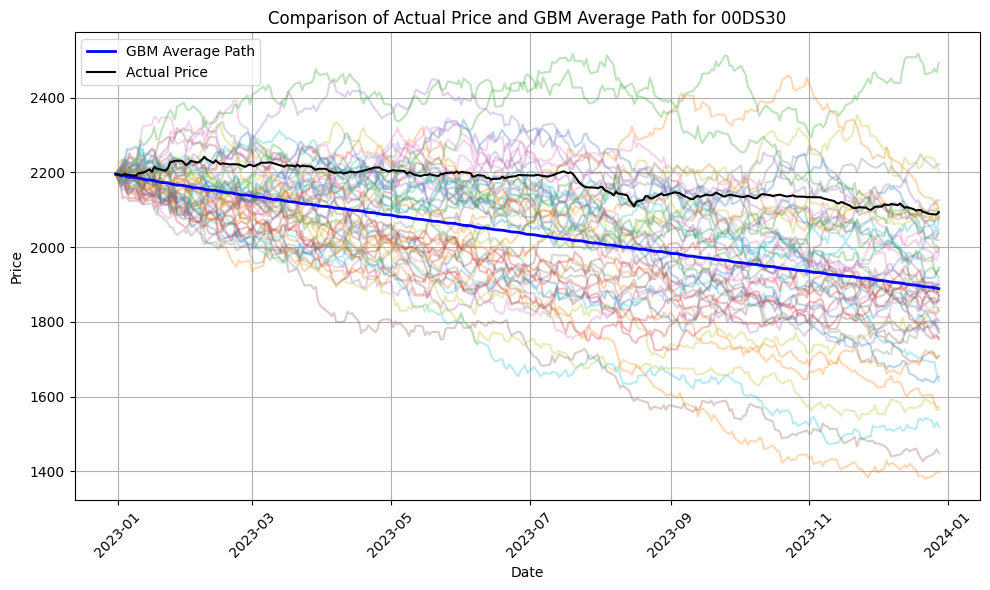

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Read the average path data for 00DS30
average_path_data = pd.read_csv('./gbm_price/00DS30.csv')

# Convert 'date' column to datetime format
average_path_data['date'] = pd.to_datetime(average_path_data['date'])

# Filter actual price data for 00DS30 from hose_df_2023
actual_price_data = dse_df_2023[dse_df_2023['ticker'] == '00DS30'][['date', 'open', 'close']]

# Get the minimum date and the corresponding open price
min_date = actual_price_data['date'].min()
min_open_price = actual_price_data[actual_price_data['date'] == min_date]['open'].values[0]

# Create a new row with date = min_date - 1 day and 'close' = min_open_price
new_row = pd.DataFrame({'date': [min_date - pd.Timedelta(days=1)], 'open': [min_open_price], 'close': [min_open_price]})

# Insert the new row at the beginning of the actual price DataFrame
actual_price_data = pd.concat([new_row, actual_price_data[['date', 'close']].rename(columns={'close': 'open'})], ignore_index=True)

# Insert the new row at the beginning of the GBM path DataFrame
new_gbm_row = pd.DataFrame({'date': [min_date - pd.Timedelta(days=1)], **{f'path_{i+1}': min_open_price for i in range(100)}})
average_path_data = pd.concat([new_gbm_row, average_path_data], ignore_index=True)

# Calculate the average GBM path
average_path_data['average'] = average_path_data.iloc[:, 1:].mean(axis=1)

# Plot actual price and average GBM path
plt.figure(figsize=(10, 6))

# Plot randomly selected 50 GBM paths
gbm_paths = random.sample(list(average_path_data.columns[1:101]), 50)
for col in gbm_paths:
    plt.plot(average_path_data['date'], average_path_data[col], alpha=0.3)

# Plot average GBM path with a bold line
plt.plot(average_path_data['date'], average_path_data['average'], label='GBM Average Path', color='blue', linewidth=2)

# Plot actual price
plt.plot(actual_price_data['date'], actual_price_data['open'], label='Actual Price', color='black')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Comparison of Actual Price and GBM Average Path for 00DS30')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
